In [2]:
import pandas as pd
from pprint import pprint
import hvplot.pandas

hvplot.hvplot_extension("matplotlib")

df = pd.read_excel("dcat-ap-no-validator-service.xlsx", na_values="Err: Zero-Division",
                   parse_dates=["CommitTime"], sheet_name="Complete Graph (all files merg", )

df = df.drop(df.columns[(df == 0.0).all()], axis=1)
shacl_columns = [col for col in df.columns if col.startswith(
    "SHACLEval") or col.startswith("CommitTime") or col.startswith("SHACL_NodeShapes")]
df_shacl = df[shacl_columns]

In [11]:
with pd.option_context('display.max_rows', 8, 'display.max_columns', None):  # more options can be specified also
    pprint(df[shacl_columns].describe())


       SHACL_NodeShapes  SHACL_NodeShapes_with_non_validations  \
count        161.000000                             161.000000   
mean          51.819876                              29.105590   
std           20.776756                              15.438427   
min            0.000000                               0.000000   
25%           46.000000                              20.000000   
50%           47.000000                              22.000000   
75%           61.000000                              34.000000   
max           82.000000                              55.000000   

       SHACLEval_ConstrainedClassesToClassesRatio  \
count                                  154.000000   
mean                                     0.449075   
std                                      0.225308   
min                                      0.000000   
25%                                      0.261905   
50%                                      0.423077   
75%                               

c:\Users\achim\anaconda3\envs\neonto_testing\Lib\site-packages\holoviews\plotting\mpl\chart.py:98: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  artist = ax.plot_date(xs, ys, '-', **plot_kwargs)[0]
c:\Users\achim\anaconda3\envs\neonto_testing\Lib\site-packages\holoviews\plotting\mpl\chart.py:98: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  artist = ax.plot_date(xs, ys, '-', **plot_kwargs)[0]


:Overlay
   .NdOverlay.I  :NdOverlay   [Metric]
      :Curve   [CommitTime]   (value)
   .NdOverlay.II :NdOverlay   [Metric]
      :Curve   [CommitTime]   (value)
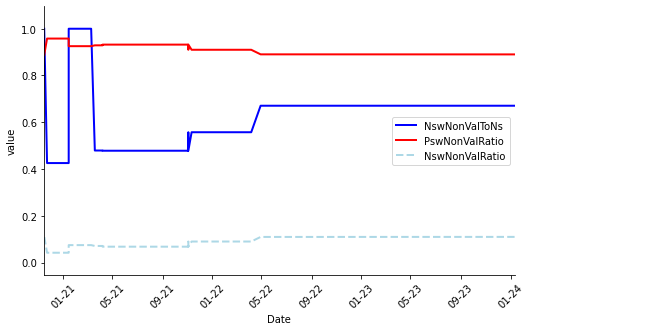

In [3]:
from matplotlib.dates import DateFormatter
date_formatter = DateFormatter("%m-%y")
df_draw = df_shacl.melt(id_vars="CommitTime", var_name="Metric", value_vars=[
                        "SHACLEval_NonValidationsRatioNodeShapesToNodeShapesRatio", "SHACLEval_PropertyShapesAnnotationsToAnnotationsRatio", "SHACLEval_NodeShapesAnnotationsToAnnotationsRatio"])
df_draw.Metric = df_draw.Metric.map({"SHACLEval_NonValidationsRatioNodeShapesToNodeShapesRatio": "NswNonValToNs",
                                    "SHACLEval_PropertyShapesAnnotationsToAnnotationsRatio": "PswNonValRatio", "SHACLEval_NodeShapesAnnotationsToAnnotationsRatio": "NswNonValRatio"})
df_draw = df_draw.dropna()
df_draw['CommitTime'] = df_draw['CommitTime'].dt.date

styles = {'NswNonValToNs': {'color': 'red', 'line_width': 2}, 'PswNonValRatio': {
    'color': 'blue', 'line_width': 2}, 'NswNonValRatio': {'color': 'green', 'line_width': 2}}

diagram1 = df_draw[df_draw.Metric != "NswNonValRatio"].hvplot.line(
    x="CommitTime", y="value", by="Metric", rot=45, height=400, xformatter=date_formatter, xlabel="Date", color=["blue", "red"])
diagram2 = df_draw[df_draw.Metric == "NswNonValRatio"].hvplot.line(
    x="CommitTime", y="value", by="Metric", rot=45, height=400, xformatter=date_formatter, xlabel="Date", color="lightblue", linestyle="--")

diagram = diagram1 * diagram2

hvplot.save(diagram, "Annotations.svg")
diagram

:NdOverlay   [Metric]
   :Curve   [CommitTime]   (value)
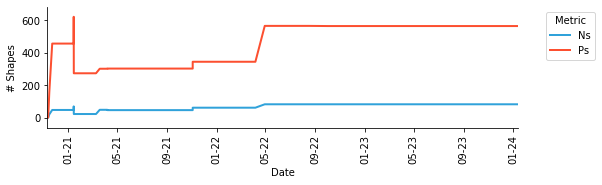

In [4]:
df_draw = df_shacl.melt(id_vars="CommitTime", var_name="Metric", value_vars=["SHACLEval_TotalPropertyShapes","SHACL_NodeShapes"])
df_draw.Metric = df_draw.Metric.map({"SHACLEval_TotalPropertyShapes":"Ps", "SHACL_NodeShapes": "Ns"})

diagram1 = df_draw.hvplot.line(x="CommitTime",y = "value",  by="Metric", xformatter= date_formatter, ylabel="# Shapes", xlabel="Date", rot=90, height=180)
hvplot.save(diagram1, "totalCount.svg")
diagram1

:Layout
   .Curve.I  :Curve   [CommitTime]   (Ns(Cls))
   .Curve.II :Curve   [CommitTime]   (NsDirect(Cls)Ratio)
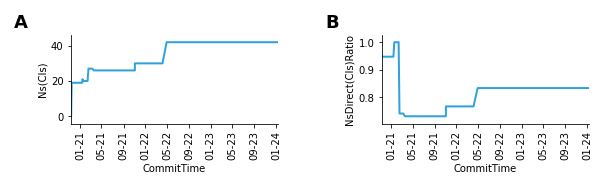

In [5]:
df_draw = df_shacl.rename(columns={"SHACLEval_TotalConstrainedClasses": "Ns(Cls)",
                       "SHACLEval_DirectlyConstrainedToConstraintClassesRatio": "NsDirect(Cls)Ratio"})
diagram1 = df_draw.hvplot.line(
    x="CommitTime", y="NsDirect(Cls)Ratio", xformatter=date_formatter, rot=90, group="df")
diagram2 = df_draw.hvplot.line(
    x="CommitTime", y="Ns(Cls)", xformatter=date_formatter, rot=90)
diagram = (diagram2 + diagram1)

hvplot.save(diagram, "classConstraints.svg")
diagram